In [13]:
import pandas as pd
import IPython.display as play

In [2]:
path = 'C:/Users/денис/Desktop/AIChallenge/data/'

In [3]:
train = pd.read_csv(f'{path}train_gt.csv', header=None, names=['names', 'labels'])

In [4]:
inndex=70
file = train.iloc[inndex]['names'] 
audio_path = f'{path}train/{file}'
train.iloc[inndex]['labels']
#audio_path = f'{path}train/ffbd950f-341c-4798-a5cf-2e465c59c48b.mp3'

1

# Первый способ

In [107]:
import librosa
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import soundfile
from warnings import warn
import webrtcvad
from librosa.core import resample
from librosa.util import frame

In [104]:
play.Audio(audio_path)

In [87]:
def rle(inarray):
    '''run length encoding. Partial credit to R rle function .
       Multi datatype anrays catered for including non Numpy
       returns: tuple (runlengths, startpositions, values)'''
    ia = np.asarray(inarray) # force mumpy
    n = len(ia)
    if n == 0:
        return (None, None, None)
    else:
        y = np.array(ia[1:] != ia[:-1])
        i = np.append (np.where(y), n - 1) # must include Last element posi
        z = np.diff(np.append (-1, i))
        p = np.cumsum(np.append (0, z))[:-1] # positions
    return(z, p, ia[i])
def showVoiceTime(vact_left, fs):
    z, p = rle(vact_left)[0], rle(vact_left)[1]
    print("start, end (s)")
    for i,j in zip(z, p):
        if (vact_left[j]==1) :
         print("{}s ,{}s".format(round(j/fs,2),round((i+j)/fs,2)))
def splitWav(path, sr = 8000) :
    data, samplerate = librosa.load(path, sr = sr, mono = False)
    data =data.T
    #samplerate, data = wavfile. read (path)
    left = []
    right = []
    for item in data:
        left.append(item[0])
        right.append(item[1])
    return np.array(left), np.array(right)
def get_wav_list(source_file):
    wav_lst = []
    for root, dirs, files in os.walk(source_file):
        for file in files:
            if file.endswith ('.wav') or file.endswith('.WAV'):
                wav_file = os.sep.join([root, file])
                wav_lst.append (wav_file)
    return wav_lst
def vad(data, fs, fs_vad=16000, hop_length=30, vad_mode=0):
    """"
    Voice activity detection.
    This was implementioned for easier use of py-webrtcvad.
    Parameters:
    data: ndarray
        numpy array of mono(1 ch) speech data.
        1 - d or 2 - d,
        if 2 - d, shape must be (1, time_length) or (time_length, 1).
        if data type is int, -32768 < data < 32767.
        if data type is float, -1 < data < 1.
    fs: int
        sampling frequency of data.
    fs_vad: int, optional
        Sampling frequency for webrtcvad.
        fs_vad must be 8000, 16000, 32000 or 48000.
        Default is 16000.
    hop_length: int, optional
        step size[milli second].
        hop_length must be 10, 20, or 30.
        Default is 0.1.
    vad_mode: int, optional
        set vad aggressiveness.
        As vad_mode increases, it becomes more aggressive.
        vad_mode must be @, 1, 2 or 3.
        Default is 0.
    Returns
    vact: ndarray
        voice activity. time length of vact is same as input data.
        If 0, it is unvoiced, 1 is voiced.
    """
    # check argument
    if fs_vad not in [8000, 16000, 32000, 48000]:
        raise ValueError('fs_vad must be 8000, 16000, 32000 or 48000.')
    if hop_length not in [10, 20, 30]:
        raise ValueError('hop_length must be 10, 20, or 30.')
    if vad_mode not in [0, 1, 2, 3]:
        raise ValueError("vad_mode must be 0, 1, 2 or 3.")
        # check data
    if data.dtype.kind == 'i':
        if data.max() > 2 ** 15 - 1 or data.min() < -2 ** 15:
            raise ValueError(
                    'when data.type is int, data must be - 32768 < data < 32767.')
        data = data.astype('f') / 2.0**15
    elif data.dtype.kind == 'f':
        if np.abs(data).max() > 1:
            raise ValueError(
                    'when data.type is float, data must be - 1.0 <= data <= 1.0.')
        data = data.astype('f')
    else:
        raise ValueError('data.dtype must be int or float.')
    data = data.squeeze()
    if not data.ndim == 1:
        raise ValueError('data must be mono (1 ch).')
    # resampling
    if fs != fs_vad:
        resampled = resample(data, fs, fs_vad)
        if np.abs(resampled).max() > 1.0:
            resampled *= (0.99 / np.abs(resampled).max())
            warn('Resampling causes data clipping. data was rescaled.')
    else:
        resampled = data
    resampled = (resampled * 2.0 ** 15).astype('int16')
    hop = fs_vad * hop_length // 1000
    framelen = resampled.size // hop + 1
    padlen = framelen * hop - resampled.size
    paded = np.lib.pad(resampled, (0, padlen), 'constant', constant_values = 0)
    framed = frame(paded, frame_length=hop, hop_length=hop).T
    vad = webrtcvad.Vad()
    vad.set_mode(vad_mode)
    valist = [vad.is_speech(tmp.tobytes(), fs_vad) for tmp in framed]
    hop_origin = fs * hop_length // 1000
    va_framed = np.zeros([len(valist), hop_origin])
    va_framed[valist] = 1
    return va_framed.reshape(-1)[:data.size]
def do_vad(wav, **kwargs):
    isDraw = kwargs.get("isDraw", True)
    sample_rate = kwargs.get("sample_rate", 8000)
    vad_mode = kwargs.get("vad_mode", 3)
    hop_length = kwargs.get("hop_length", 10)
    min_vad_wav_time = kwargs.get("min_vad_wav_time", 0.5)
    time = np.linspace(0, len(wav) / sample_rate, len(wav))
    vact = vad(wav, sample_rate, fs_vad=sample_rate, hop_length=hop_length, vad_mode=vad_mode)
    r = rle(vact)
    z, p = r[0], r[1]
    # ABARGS FAA NEAR BREE
    for i, j in zip(z, p):
        # — print("{}s ,{}s".format(j/fs,i/fs) )
        if i<(min_vad_wav_time * sample_rate) and vact[j] == 0:
            vact[j:j + i] = vact[j] * -1 + 1
    if isDraw:
        fig, ax1 = plt.subplots(figsize=(24, 6))
        ax1.plot(time, wav, label='speech waveform')
        ax1.set_xlabel("TIME [s]")
        ax2 = ax1.twinx()
        wav_len = min(vact.size, time.size)
        ax2.plot(time[0: wav_len], vact[0: wav_len], color = "r", label = 'vad')
        plt.yticks([0, 1], ('unvoice', 'voice'))
        ax2.set_ylim([-0.01, 1.01])
        plt.legend()
        plt.show()
    return vact
def splitwavandvad(wav_path) :
    sample_rate = 8000
    vad_level = 3
    # — Left_wav_bytes = splitwav(wav_path) [0]
    vact_left = do_vad(wav = splitWav(wav_path)[0],**dict (vad_mode=3,min_vad_wav_time=0.5))
    showVoiceTime(vact_left, sample_rate)
    vact_right = do_vad(wav = splitWav(wav_path)[1],**dict(vad_mode=3,min_vad_wav_time=0.5))
    showVoiceTime(vact_right, sample_rate)
def wav_vad_double(zuoxi_audio_data, user_audio_data, sample_rate = 8000, min_vad_time = 0.5):
    
    vact_zuoxi = do_vad(zuoxi_audio_data, **dict(vad_mode=3,min_vad_wav_time = min_vad_wav_time))
    vact_user = do_vad(user_audio_data, **dict(vad_mode=3,min_vad_wav_time = min_vad_wav_time))
    
    margin_len = 3 * sample_rate 
    r = rle(vact_zuoxi) 
    z, p= r[0], r[1]
   
    last_end = -margin_len
    for i,j in zip(z,p):
        if vact_zuoxi[j] == 1:
            start_id = j
            end_id = i+j
            if start_id -last_end < 8000:
                last_end = end_id
                continue
            last_end = end_id
            vact_zuoxi[start_id:start_id+margin_len] = 0
    vact_left = (1-vact_zuoxi)* vact_user
           
    r = rle(vact_left) 
    z, p= r[0], r[1] 
    nonsil_audio = [] 
    for i,j in zip(z,p): 
        if vact_left[j]==1: 
            nonsil_audio.extend(user_audio_data[j:i+j]) 
    return np.array(nonsil_audio)
def wav_vad(audio_data, sample_rate = 8000, min_vad_wav_time = 0.5):
    vact_left = do_vad(audio_data, **dict(vad_mode=3,min_vad_wav_time = min_vad_wav_time))
    r = rle(vact_left)
    z, p= r[0], r[1]
    nonsil_audio = []
    for i,j in zip(z,p):
        if vact_left[j]==1:
            nonsil_audio.extend(audio_data[j:i+j])
    return np.array(nonsil_audio)
def save_wav(audio, fx, sr = 8000):
    soundfile.write(fx, audio, sr, 'PCM_16')

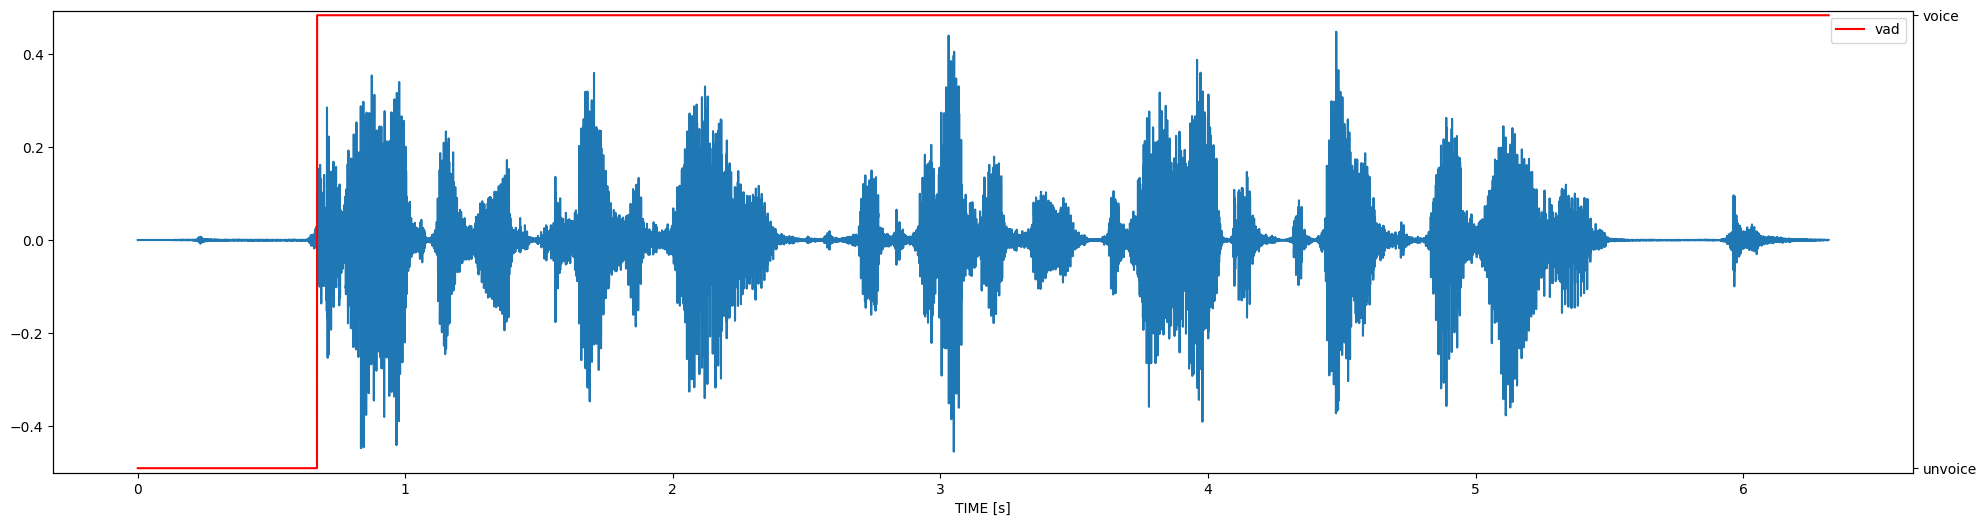

[ 0.02071482  0.01873144 -0.00910983 ...  0.00018476  0.00010606
  0.00027192]


In [105]:
audio, sr = librosa.load(audio_path, sr = 8000, mono = True)
no_audio = wav_vad(audio)
print(no_audio)
save_wav(audio, "test001.wav")

In [106]:
play.Audio('C:/Users/денис/Desktop/AIChallenge/test001.wav')

# Второй способ (пока лучший, и по объёму и по качеству)

In [ ]:
from rnnoise_wrapper import RNNoise
from pydub import AudioSegment

denoiser = RNNoise()

audio = AudioSegment.from_mp3(audio_path)
denoised_audio = denoiser.filter(audio)
# denoised_audio это объект типа pydub.AudioSegment
# Если вы не запустили на винде то ниче страшного